#Loading Libraries


In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")


import os
import gc
import string
import math
import scipy as sp
import random
from pandas import Timestamp

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Using Cuda 




we can accelerate deep learning and other compute-intensive apps by taking advantage of CUDA and the parallel processing power of GPUs. ... CUDA enables developers to speed up compute-intensive applications by harnessing the power of GPUs for the parallelizable part of the computation.

In [ ]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('I will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

I will use the GPU: Tesla T4


#Loading and preparing training data & EDA ( Exploratory data analysis )

Exploratory Data Analysis (EDA) refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [ ]:
updated_train=pd.read_csv("/content/drive/MyDrive/Course/Courses/Competitions/Sem2/Others/Dphi/Train_Data.csv")
updated_test=pd.read_csv("/content/drive/MyDrive/Course/Courses/Competitions/Sem2/Others/Dphi/Test_Data.csv")

In [ ]:
updated_train.head()

,review,sentiment
0,think robert ryans best film portrayed someone...,1
1,juano hernandez exceptional actor played suppo...,1
2,shocked sign indicate cash,0
3,sat another ten minute finally gave left,0
4,igo charger tip really great,1


In [ ]:
updated_test.shape

(686, 1)

In [ ]:
updated_test.head()

,review
0,great service food
1,pairing iphone could happier far
2,plot hole pair fishnet stocking direction edit...
3,surely doesnt know make coherent action movie ...
4,still quite interesting entertaining follow


In [ ]:
print('There are {} rows and {} columns in train'.format(updated_train.shape[0],updated_train.shape[1]))
print('There are {} rows and {} columns in train'.format(updated_test.shape[0],updated_test.shape[1]))

There are 2060 rows and 2 columns in train
There are 686 rows and 1 columns in train


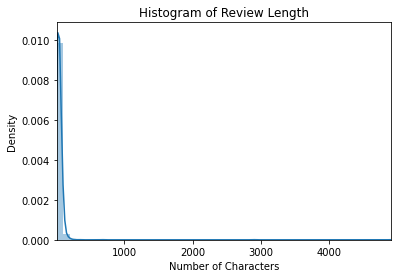

In [ ]:
# updated_train["review_length"] = updated_train["review"].apply(len)
# sns.distplot(updated_train["review_length"],bins=50)
# plt.xlim(min(updated_train["review_length"]), max(updated_train["review_length"]))
# plt.title("Histogram of Review Length")
# plt.xlabel("Number of Characters")
# plt.ylabel("Density")
# plt.show()

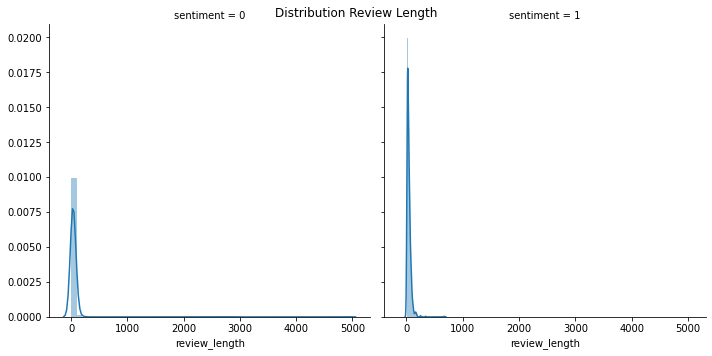

In [ ]:
# g = sns.FacetGrid(updated_train, col="sentiment", height=5)
# g = g.map(sns.distplot, "review_length")
# plt.suptitle("Distribution Review Length")
# plt.show()

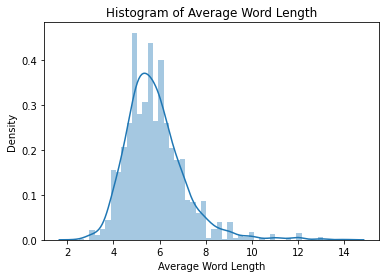

In [ ]:
# def avg_word_length(x):
#     return np.sum([len(w) for w in x.split()]) / len(x.split())

# updated_train["avg_word_length"] = updated_train["review"].apply(avg_word_length)
# sns.distplot(updated_train["avg_word_length"])
# plt.title("Histogram of Average Word Length")
# plt.xlabel("Average Word Length")
# plt.ylabel("Density")
# plt.show()

#Data Pre-processing

In [ ]:
import re
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove hashtag sign
    #text=re.sub(r"#","",text)   
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #text=re.sub(r"@","",text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

updated_train['review'] = updated_train['review'].apply(preprocess)
updated_test['review'] = updated_test['review'].apply(preprocess)
updated_train = updated_train[updated_train["review"]!='']

In [ ]:
updated_train = updated_train[["review","sentiment"]]
updated_train.head()

,review,sentiment
0,think robert ryans best film portrayed someone...,1
1,juano hernandez exceptional actor played suppo...,1
2,shocked sign indicate cash,0
3,sat another ten minute finally gave left,0
4,igo charger tip really great,1


In [ ]:
updated_train["sentiment"].value_counts()

1    1039
0    1021
Name: sentiment, dtype: int64

In [ ]:
updated_train.shape

(2060, 2)

In [ ]:
# Get the lists of lyrics and their labels.
texts = updated_train.review.values
labels = updated_train.sentiment.values

In [ ]:
!pip install transformers

In [ ]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
import torch
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2)
model.cuda()

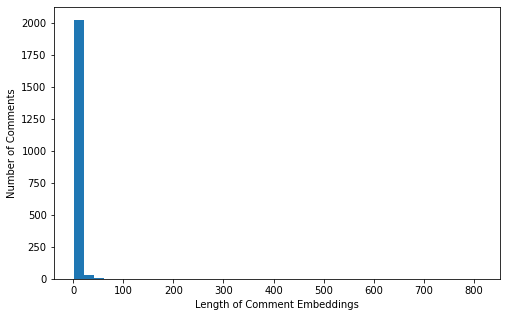

In [ ]:
#to show length of embedding will be helpful to determine maximum length of comments and padding threshold
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return
plot_sentence_embeddings_length(texts, tokenizer)

In [ ]:
indices=tokenizer.batch_encode_plus(texts,max_length=64,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

In [ ]:
from sklearn.model_selection import train_test_split

# Use 99.9% for training and 0.1% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.001)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.001)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 10e-6, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 40

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
#import time

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 10 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors: [0]: input ids ,[1]: attention masks,[2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients.
        model.zero_grad()        

        # Evaluate the model on this training batch.
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0. to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")


======== Epoch 1 / 40 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:04.
  Batch    20  of     65.    Elapsed: 0:00:07.
  Batch    30  of     65.    Elapsed: 0:00:11.
  Batch    40  of     65.    Elapsed: 0:00:15.
  Batch    50  of     65.    Elapsed: 0:00:19.
  Batch    60  of     65.    Elapsed: 0:00:23.

  Average training loss: 0.67
  Training epoch took: 0:00:25

======== Epoch 2 / 40 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:04.
  Batch    20  of     65.    Elapsed: 0:00:08.
  Batch    30  of     65.    Elapsed: 0:00:12.
  Batch    40  of     65.    Elapsed: 0:00:16.
  Batch    50  of     65.    Elapsed: 0:00:20.
  Batch    60  of     65.    Elapsed: 0:00:24.

  Average training loss: 0.46
  Training epoch took: 0:00:25

======== Epoch 3 / 40 ========
Training...
  Batch    10  of     65.    Elapsed: 0:00:04.
  Batch    20  of     65.    Elapsed: 0:00:08.
  Batch    30  of     65.    Elapsed: 0:00:11.
  Batch    40  of     65.    Elapsed: 0

In [ ]:
# Validation
print("")
print("Running Validation...")

t0 = time.time()
model.eval()

preds=[]
true=[]

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:00


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [ ]:
comments1 = updated_test.review.values

indices1=tokenizer.batch_encode_plus(comments1,max_length=64,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  
  
  # Store predictions and true labels
  predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 686 test sentences...


In [ ]:
#sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
submit=pd.DataFrame({'prediction':flat_predictions})
#submit.to_csv('submission.csv',index=False)

In [ ]:
submit.head()

,prediction
0,1
1,1
2,0
3,0
4,1


In [ ]:
submit.to_csv('submission_3_sentiment_Clssification_nlp.csv',index=False)